## 4. 데이터 기반 금융

### 4.3 데이터 입수

In [1]:
import yfinance as yf
import pandas as pd

In [2]:
symbols = ['AAPL', 'MSFT', 'NFLX', 'AMZN']

In [3]:
data = yf.download(symbols, start='2019-07-01', end='2020-07-02')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed


In [4]:
data['Close'].info()
data = data['Close']

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 254 entries, 2019-07-01 to 2020-07-01
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    254 non-null    float64
 1   AMZN    254 non-null    float64
 2   MSFT    254 non-null    float64
 3   NFLX    254 non-null    float64
dtypes: float64(4)
memory usage: 9.9 KB


In [5]:
data.tail()

Ticker,AAPL,AMZN,MSFT,NFLX
Date,,,,
2020-06-25,88.778671,137.729004,192.295258,465.910004
2020-06-26,86.050896,134.643494,188.446259,443.399994
2020-06-29,88.034088,134.018997,190.471573,447.239990
2020-06-30,88.768951,137.940994,195.337967,455.040009
2020-07-01,88.601044,143.934998,196.480164,485.640015


### 4.4 규범적 이론의 재고

과거에는 규범적 금융 이론을 배우고 공부하는 데 많은 제약을 받았다.
하지만 지금은 누구나 분석이 가능하다.

#### 4.4.2 평균-분산 포트폴리오 이론

In [6]:
import numpy as np
import pandas as pd
from pylab import plt, mpl
from scipy.optimize import minimize
plt.style.use('seaborn-v0_8')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(precision=5, suppress=True, formatter={'float': lambda x: f'{x:6.3f}'})

In [7]:
url = ' http://hilpisch.com/aiif_eikon_eod_data.csv'

In [8]:
raw = pd.read_csv(url, index_col=0, parse_dates=True).dropna()

In [9]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2516 non-null   float64
 1   MSFT.O  2516 non-null   float64
 2   INTC.O  2516 non-null   float64
 3   AMZN.O  2516 non-null   float64
 4   GS.N    2516 non-null   float64
 5   SPY     2516 non-null   float64
 6   .SPX    2516 non-null   float64
 7   .VIX    2516 non-null   float64
 8   EUR=    2516 non-null   float64
 9   XAU=    2516 non-null   float64
 10  GDX     2516 non-null   float64
 11  GLD     2516 non-null   float64
dtypes: float64(12)
memory usage: 255.5 KB


In [10]:
symbols = ['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GLD']

In [11]:
rets = np.log(raw[symbols] / raw[symbols].shift(1)).dropna()

<Axes: xlabel='Date'>

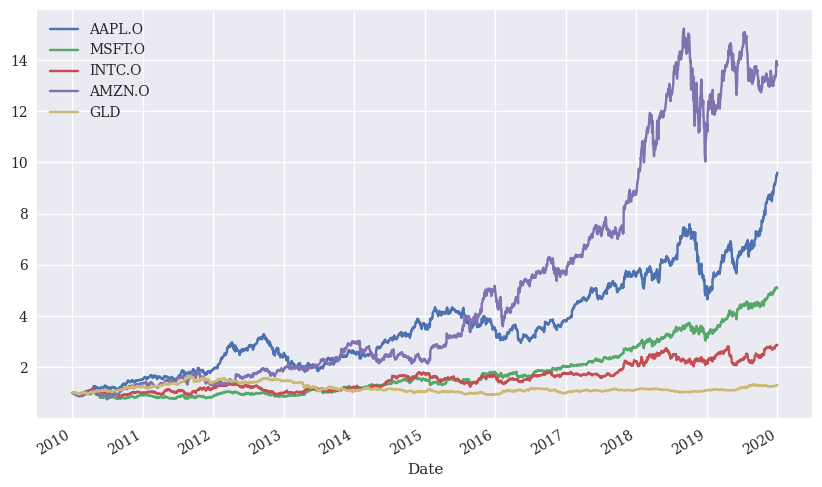

In [12]:
(raw[symbols] / raw[symbols].iloc[0]).plot(figsize=(10,6))

각 종목에 대해서 정규화된 시계열을 그린 것이다.
iloc[0]을 통해서 초기 값으로 모든 값을 나눳다.
이로 이해 초기에 비해 몇배가 감소, 증가 했는지 알 수 있다.

In [13]:
weights = len(rets.columns) * [1/len(rets.columns)] # 각 종목에 대해 동일한 가중치 부여

In [14]:
def port_return(rets, weights):
    return np.dot(rets.mean(), weights) * 252 # 포트폴리오 수익률

In [15]:
port_return(rets,weights)

np.float64(0.156947646530181)

In [16]:
def port_volatility(rets, weights):
    return np.dot(weights, np.dot(rets.cov() * 252, weights)) ** 0.5 #포트폴리오 변동성

In [17]:
port_volatility(rets, weights)

np.float64(0.16106507848480675)

In [18]:
def port_sharpe(rets, weights):
    return port_return(rets, weights) / port_volatility(rets, weights) #포트폴리오 샤프 비율

In [19]:
port_sharpe(rets, weights)

np.float64(0.9744362217225496)

해당 포트폴리오의 수익률과 변동성, 샤프 비율을 계산했다.

In [20]:
w = np.random.random((1000, len(symbols)))
w = (w.T / w.sum(axis=1)).T

In [21]:
w[:5]

array([[ 0.188,  0.415,  0.191,  0.022,  0.183],
       [ 0.225,  0.201,  0.219,  0.060,  0.295],
       [ 0.399,  0.033,  0.056,  0.092,  0.420],
       [ 0.415,  0.319,  0.098,  0.094,  0.074],
       [ 0.249,  0.098,  0.175,  0.189,  0.289]])

In [22]:
pvr = [(port_volatility(rets[symbols], weights),\
        port_return(rets[symbols], weights))\
        for weights in w]
pvr = np.array(pvr)

In [23]:
psr = pvr[:, 1] / pvr[:, 0]

Text(0.5, 1.0, 'AAPL.O | MSFT.O | INTC.O | AMZN.O | GLD')

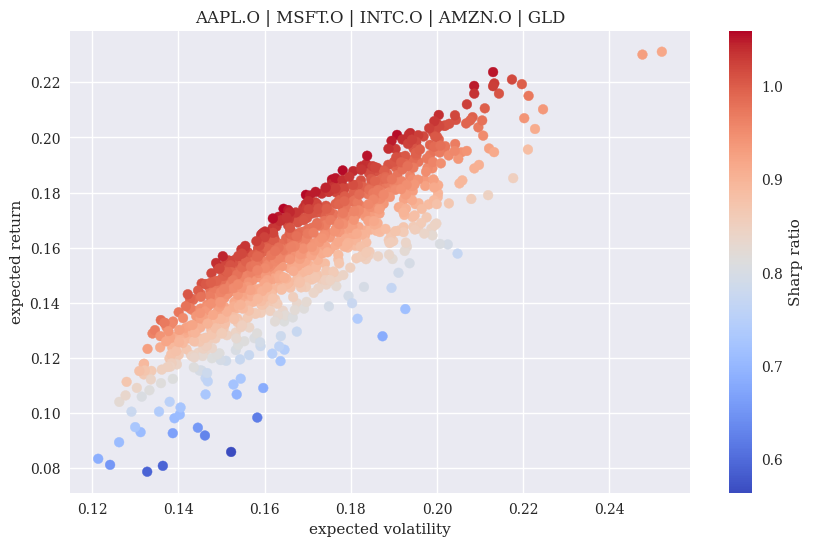

In [24]:
plt.figure(figsize=(10, 6))
fig = plt.scatter(pvr[:, 0], pvr[:, 1],\
                  c=psr, cmap='coolwarm')
cb = plt.colorbar(fig)
cb.set_label('Sharp ratio')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.title(' | '.join(symbols))

샤프비율이 높을수록 낮은 위험으로 높은 수익률을 얻을 수 있다.

In [25]:
bnds = len(symbols) * [(0,1),]

In [26]:
cons = {'type' : 'eq', 'fun': lambda weights: weights.sum() - 1} # 가중치의 합이 1이라는 제약
#type에는 eq (equality), 뒤의 함수가 0이 되어야 한다는 뜻
#fun에는 람다 표현식인데, 그 함수의 값이 0이 되어야함.

In [27]:
opt_weights = {}
for year in range(2010, 2019):
    rets_ = rets[symbols].loc[f"{year}-01-01":f"{year}-12-31"]
    ow = minimize(
        lambda weights: -port_sharpe(rets_, weights),
        len(symbols) * [1 / len(symbols)],
        bounds=bnds,
        constraints=cons)["x"]
    opt_weights[year] = ow

In [28]:
opt_weights

{2010: array([ 0.366,  0.000,  0.000,  0.056,  0.578]),
 2011: array([ 0.543,  0.000,  0.077,  0.000,  0.380]),
 2012: array([ 0.324,  0.000,  0.000,  0.471,  0.205]),
 2013: array([ 0.012,  0.305,  0.219,  0.464,  0.000]),
 2014: array([ 0.452,  0.115,  0.419,  0.000,  0.015]),
 2015: array([ 0.000,  0.000,  0.000,  1.000,  0.000]),
 2016: array([ 0.150,  0.260,  0.000,  0.058,  0.533]),
 2017: array([ 0.231,  0.203,  0.031,  0.109,  0.426]),
 2018: array([ 0.000,  0.295,  0.000,  0.705,  0.000])}

각 년도 별 포트폴리오의 수익을 극대화 하기 위한 비율을 구했다.
하지만 이런 방식으로는 어떠한 종목이 100%를 가져가는 극단적인 현상이 발견된다.

아래 코드는 전년도 실현 데이터로 계산한 포트폴리오 기대 수익률과 실제 데이터로 계산한 포트폴리오 실현 수익률을 비교한다.

In [29]:
res = pd.DataFrame()
for year in range(2010, 2019):
    # 기대 포트폴리오 통계
    rets_ = rets[symbols].loc[f'{year}-01-01':f'{year}-12-31']
    epv = port_volatility(rets_, opt_weights[year])
    epr = port_return(rets_, opt_weights[year])
    esr = epr / epv
    # 실제 포트폴리오 통계
    rets_ = rets[symbols].loc[f'{year + 1}-01-01':f'{year+1}-12-31']
    rpv = port_volatility(rets_, opt_weights[year])
    rpr = port_return(rets_, opt_weights[year])
    rsr = rpr /rpv
    res = pd.concat([res, pd.DataFrame({'epv':epv, 'epr':epr, 'esr':esr,'rpv':rpv, 'rpr':rpr,'rsr':rsr},index=[year+ 1])])

In [30]:
res

,epv,epr,esr,rpv,rpr,rsr
2011,0.157440,0.303003,1.924564,0.160622,0.133836,0.833235
2012,0.173279,0.169321,0.977156,0.182292,0.161375,0.885256
2013,0.202460,0.278459,1.375378,0.168714,0.166897,0.989228
2014,0.181544,0.368961,2.032353,0.197798,0.026830,0.135645
2015,0.160340,0.309486,1.930190,0.211368,-0.024560,-0.116194
2016,0.326730,0.778330,2.382179,0.296565,0.103870,0.350242
2017,0.106148,0.090933,0.856663,0.079521,0.230630,2.900235
2018,0.086548,0.260702,3.012226,0.157337,0.038234,0.243004
2019,0.323796,0.228008,0.704174,0.207672,0.275819,1.328147


In [31]:
res.mean()

epv    0.190920
epr    0.309689
esr    1.688320
rpv    0.184654
rpr    0.123659
rsr    0.838755
dtype: float64

In [32]:
res[['epv','rpv']].corr()

,epv,rpv
epv,1.000000,0.765733
rpv,0.765733,1.000000


<Axes: title={'center': 'Expected vs. Realized Portfolio Volatility'}>

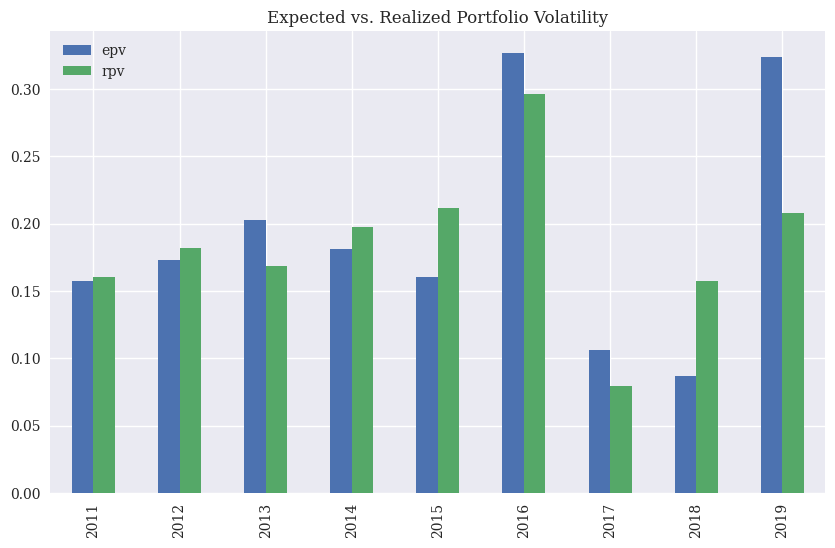

In [33]:
res[['epv','rpv']].plot(kind='bar', figsize=(10,6), title='Expected vs. Realized Portfolio Volatility')

기대변동성과 실현변동선은 포트폴리오 변동성을 예측하는 데에는 좋은 성능을 보인다.

In [34]:
res[['esr', 'rsr']].corr()

,esr,rsr
esr,1.000000,-0.698607
rsr,-0.698607,1.000000


<Axes: title={'center': 'Expected vs. Realized Sharpe Ratio'}>

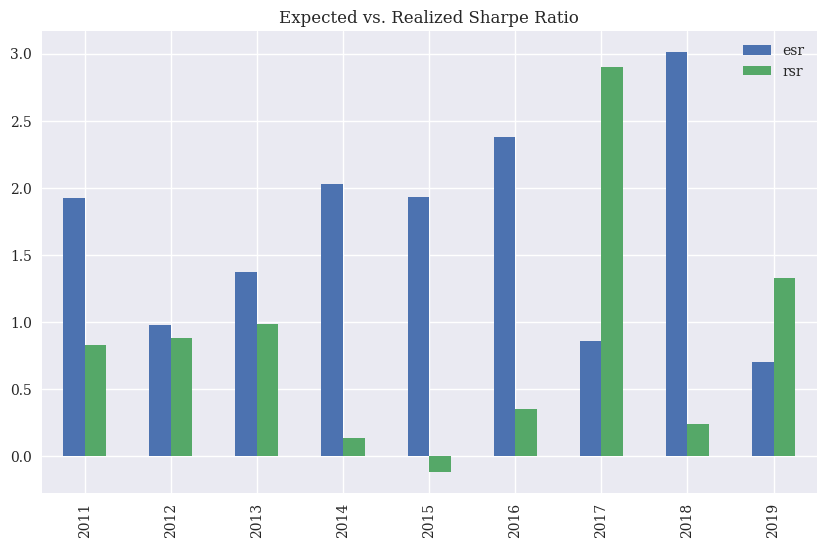

In [35]:
res[['esr', 'rsr']].plot(kind='bar', figsize=(10, 6), title='Expected vs. Realized Sharpe Ratio')

위의 표와 같이 기대 수익률과 실현 수익률의 경우에는 반대의 결과가 나왔다.   
평균-분산 포트폴리오이론은 포트폴리오 수익률을 예측하는 데 실패했다.

#### 4.4.3 자본자산 가격결정 모형

자본자산 가격결정 모형을 현실에 적용할 때도 비슷한 방법으로 가능하다.   
내년의 주식 기대 수익률은 주어진 베타와 시장 포트폴리오의 성능을 이용하여 계산한다.   
아래는 S&P 500을 이용한다.

In [36]:
r = 0.005
market = '.SPX'

In [37]:
rets = np.log(raw / raw.shift(1)).dropna()

In [38]:
res = pd.DataFrame()

In [40]:
for sym in rets.columns[:4]:
    print('\n' + sym)
    print(54 * '=')
    for year in range(2010, 2019):
        rets_ = rets.loc[f'{year}-01-01':f'{year}-12-31']
        muM = rets_[market].mean() * 252
        cov = rets_.cov().loc[sym, market]
        var = rets_[market].var()
        beta = cov / var
        rets_ = rets.loc[f'{year + 1}-01-01':f'{year+1}-12-31']
        muM = rets_[market].mean() * 252
        mu_capm = r + beta * (muM - r)
        mu_real = rets_[sym].mean() * 252
        res = pd.concat([res, pd.DataFrame({'symbol': sym, 'mu_capm': mu_capm, 'mu_real': mu_real}, index=[year+1])], sort=True)
        print('{} | beta: {:.3f} | mu_capm: {:6.3f} | mu_real: {:6.3f}'.format(year + 1, beta, mu_capm, mu_real))


AAPL.O
2011 | beta: 1.052 | mu_capm: -0.000 | mu_real:  0.228
2012 | beta: 0.764 | mu_capm:  0.098 | mu_real:  0.275
2013 | beta: 1.266 | mu_capm:  0.327 | mu_real:  0.053
2014 | beta: 0.630 | mu_capm:  0.070 | mu_real:  0.320
2015 | beta: 0.833 | mu_capm: -0.005 | mu_real: -0.047
2016 | beta: 1.144 | mu_capm:  0.103 | mu_real:  0.096
2017 | beta: 1.009 | mu_capm:  0.180 | mu_real:  0.381
2018 | beta: 1.379 | mu_capm: -0.091 | mu_real: -0.071
2019 | beta: 1.252 | mu_capm:  0.316 | mu_real:  0.621

MSFT.O
2011 | beta: 0.890 | mu_capm:  0.001 | mu_real: -0.072
2012 | beta: 0.816 | mu_capm:  0.104 | mu_real:  0.029
2013 | beta: 1.109 | mu_capm:  0.287 | mu_real:  0.337
2014 | beta: 0.876 | mu_capm:  0.095 | mu_real:  0.216
2015 | beta: 0.955 | mu_capm: -0.007 | mu_real:  0.178
2016 | beta: 1.249 | mu_capm:  0.113 | mu_real:  0.113
2017 | beta: 1.224 | mu_capm:  0.217 | mu_real:  0.321
2018 | beta: 1.303 | mu_capm: -0.086 | mu_real:  0.172
2019 | beta: 1.442 | mu_capm:  0.364 | mu_real:  

CAPM의 예측력은 특정 종목에 대해 상당히 낮거나 없다.   
평균-분산 포트폴리오 이론과 CAPM의 가정이 같기 때문이다.   
가정은 투자자들이 포트폴리오 및 주식의 기대 수익률과 예상 변동성에만 신경을 쓴다는 것이다.

#### 4.4.4 차익거래 가격결정 이론

자본자산 가격결정 모형의 예측력은 이전 수치 예제의 결과를 고려할 때 상당히 제한적이다.   
시장 포트폴리오 성능만으로도 주식 수익률의 변동을 설명하기에 충분한지의 여부에 관해 주요한 의문을 가지게 되는데, 차익거래 가격결정 이론의 대답(APT)은 '그렇지 않다'이다.

ValueError: could not convert string to float: 'AMZN.O'